In [1]:
import tensorflow as tf
import utility.initialize_tf
from utility.data_loading import *
import numpy as np
from sklearn.model_selection import train_test_split
from utility.display_prediction_results import *
from tensorflow.keras.layers import Dense, Dropout
from matplotlib import pyplot as plt
from utility.plotting_helpers import *
from utility.data_preprocessing import *
import matplotlib as mpl
print(tf.version.VERSION)
%matplotlib inline
mpl.rcParams['figure.figsize'] = [20, 20]
mpl.rcParams['figure.dpi'] = 72

2.5.0
2.5.0
2.5.0


In [2]:
model_name = f"saved_models\\result_models\\sim_with_gaussian_noise"
training_data_name = "fd=0.3-0.7_hdf5"
testing_data = "califa_s_1.0"
training_validation_split = 0.7

In [3]:
x_dataset, y_dataset, metadata = load_hdf5_data(name=training_data_name, count=None)
num_classes = 2 # get from unique

x_cal, y_cal, metadata = load_hdf5_data(name=testing_data)
x_cal = np.expand_dims(x_cal, axis=3)
y_cal = np.expand_dims(y_cal, axis=1)


E:\Anaconda3\envs\hon-tf-2.5.0\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is a Python keyword: 'class'; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


(54000, 100, 100)
(79, 100, 100)


In [4]:
add_point_sources(x_dataset)
add_background_galaxies(x_dataset)
#apply_gaussian_PSF(x_dataset, 0.218598726) # General Gaussian PSF 0.218598726 0.573292215 1.3 20.84 8.85
add_gaussian_noise(x_dataset)#, noise_range=[0.02, 0.01])
#apply_moffat_PSF(x_dataset, 1.642657, 4.765) #4.765 #g 0.65049197562297747917932881055243
apply_gaussian_PSF(x_dataset, 1.394089) # 0.218598726

x_dataset = np.expand_dims(x_dataset, axis=3)
y_dataset = np.expand_dims(y_dataset, axis=1)

64


(54000, 100, 100, 1)


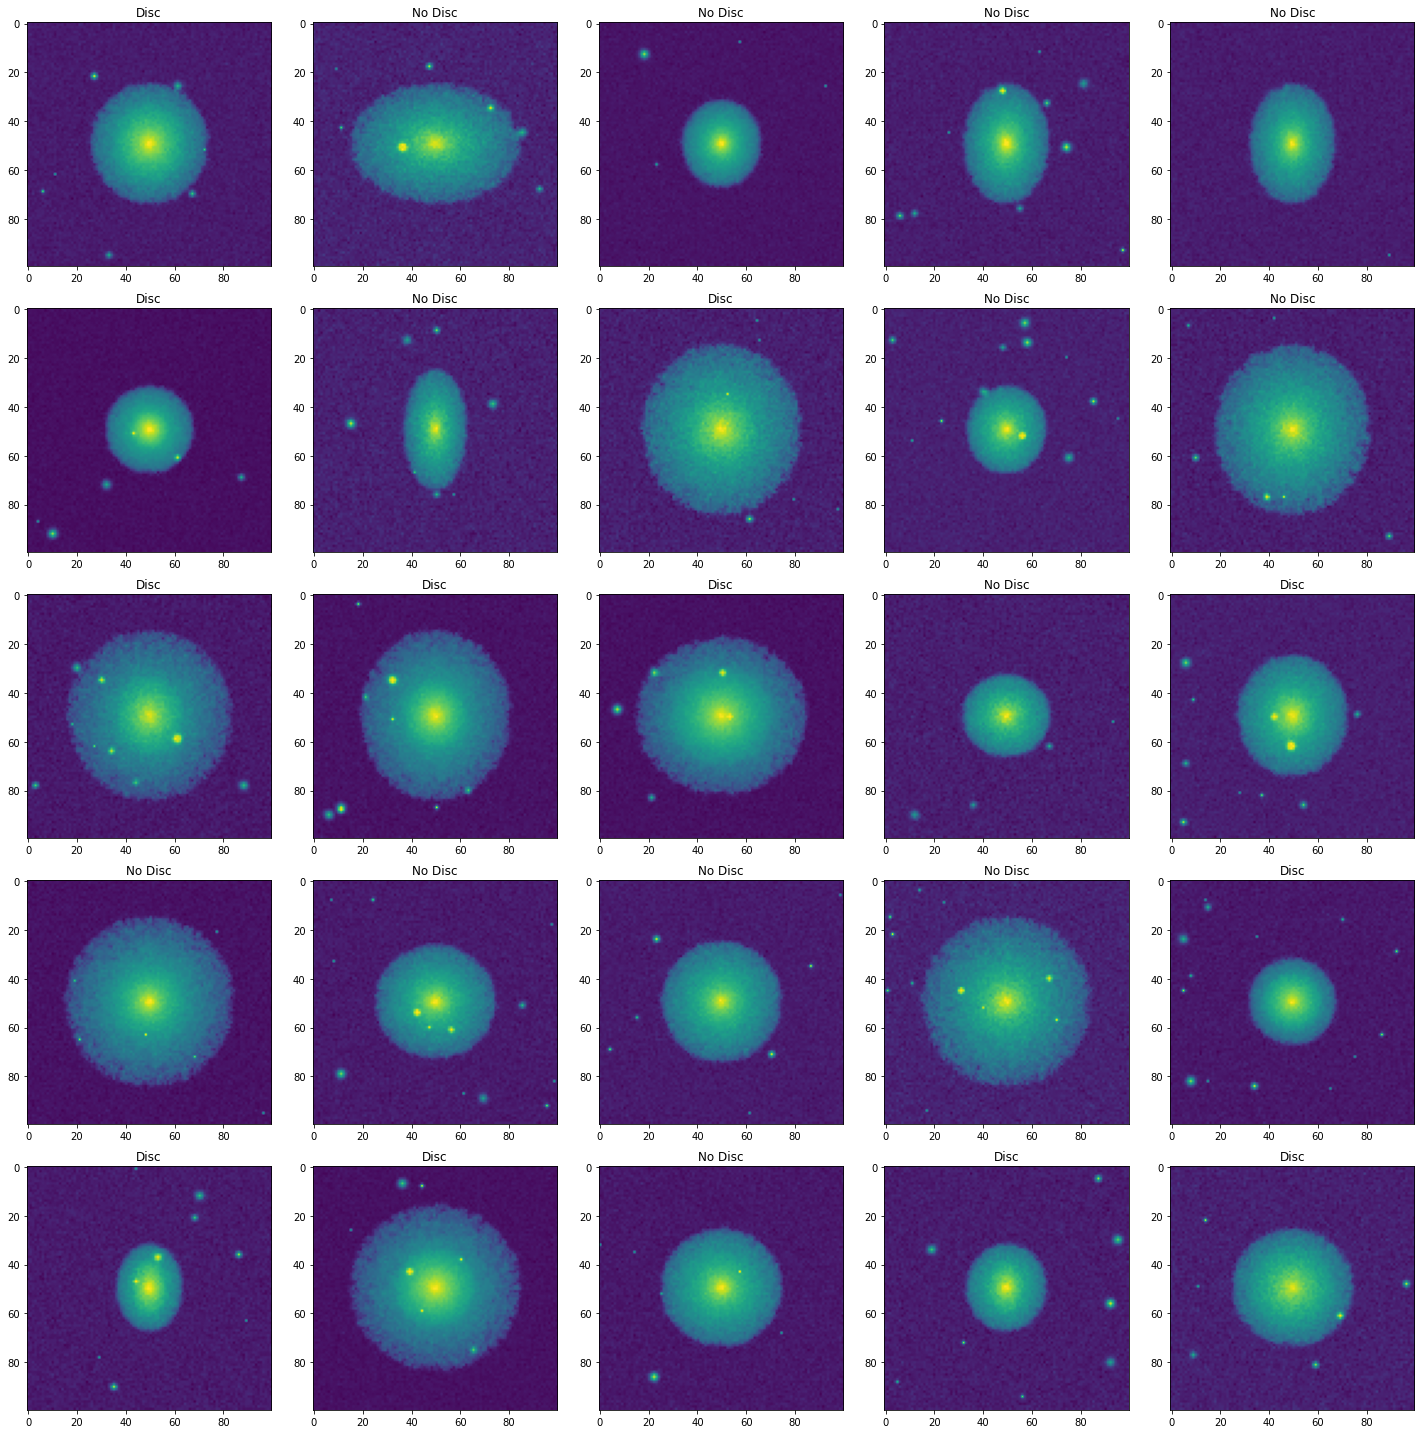

In [5]:
plot_classification_results(images=x_dataset, y_preds=y_dataset, y_trues=y_dataset, y_labels=("No Disc", "Disc"), random_sample=True)
#x_dataset = np.expand_dims(x_dataset, axis=1)
print(x_dataset.shape)

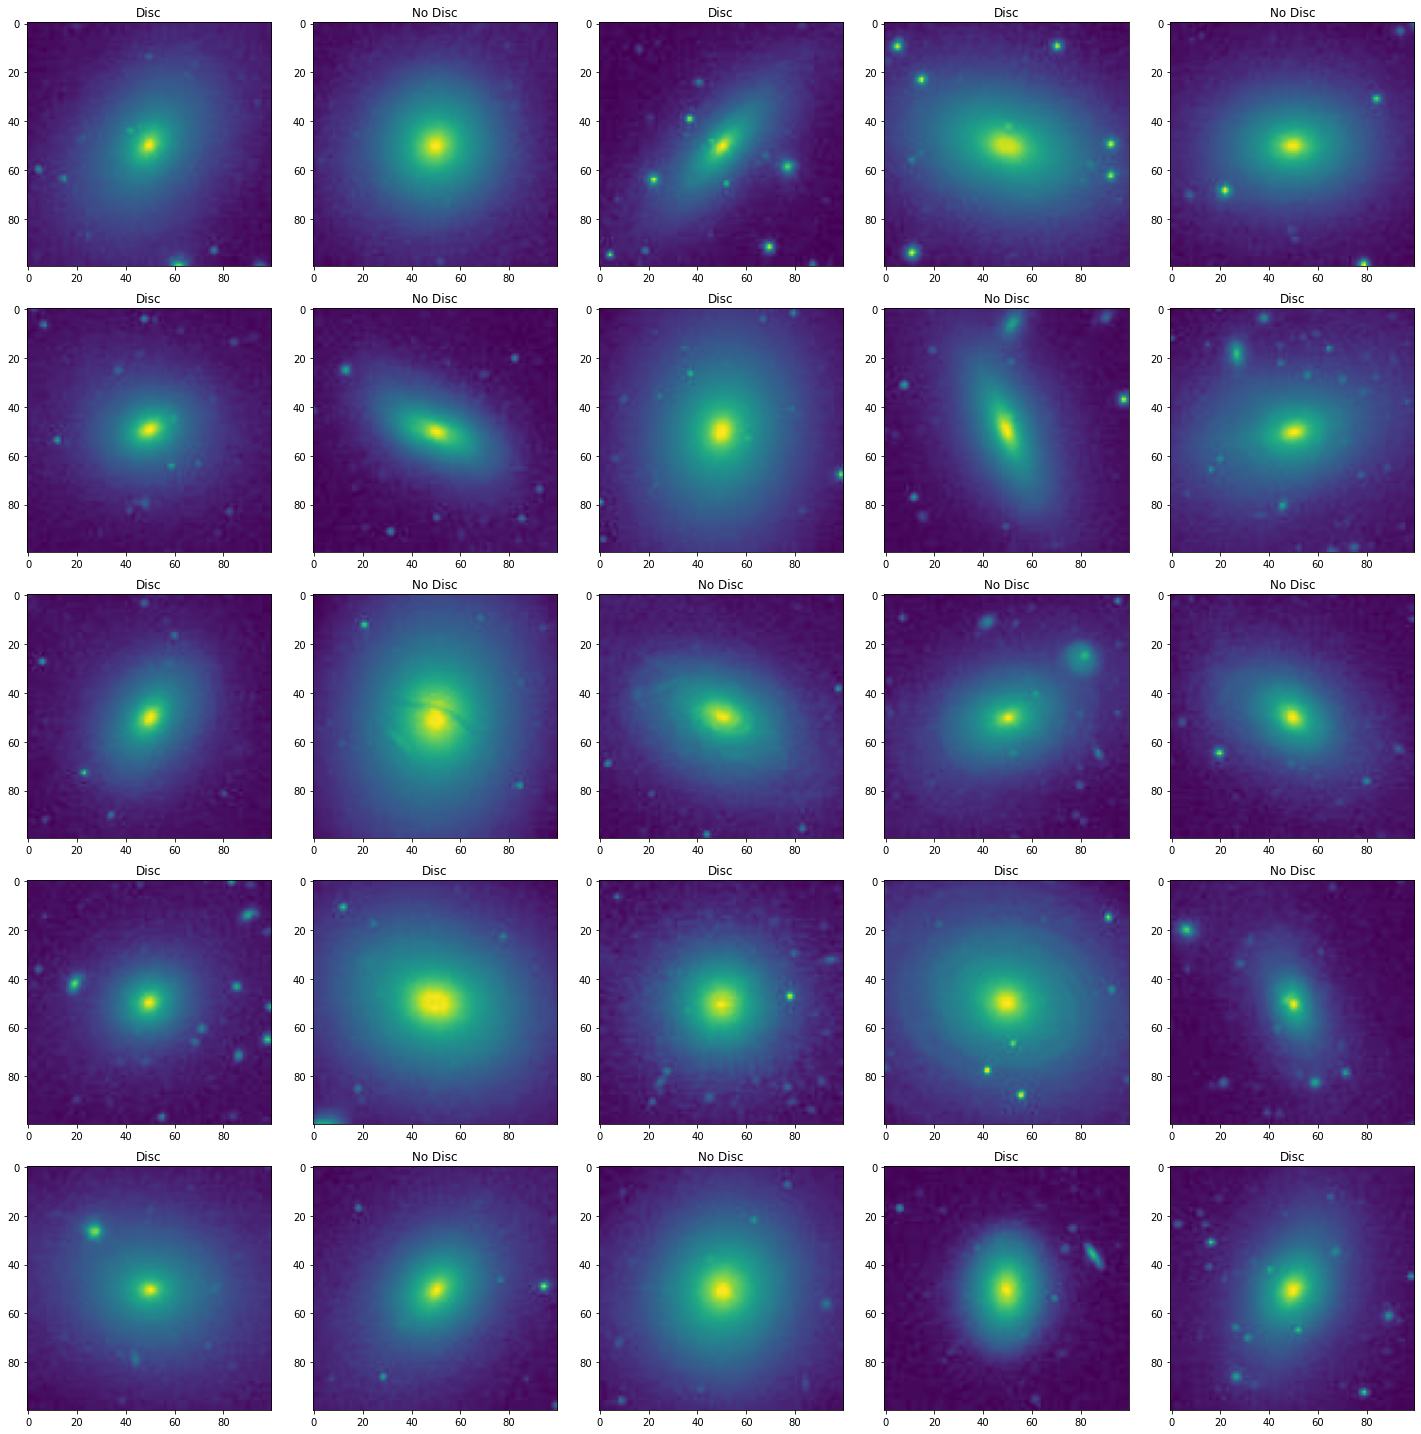

In [6]:
plot_classification_results(images=x_cal, y_preds=y_cal, y_trues=y_cal, y_labels=("No Disc", "Disc"), random_sample=True)

In [7]:
# def train_model(x_dataset, y_dataset, x_val, Y_val):
#     from sklearn import model_selection
#     x_train, x_test, y_train, y_test = model_selection.train_test_split(x_dataset, y_dataset, train_size=0.8, random_state=1)

#     callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

#     epochs = 15
#     batch_size = 128
#     model = tf.keras.Sequential([
#         tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
#                         activation='relu',
#                         input_shape=x_dataset[0].shape),
#         tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#         tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
#         tf.keras.layers.Dropout(0.25),
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(128, activation='relu'),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.Dense(num_classes, activation='softmax')
#     ])

#     model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
#                     optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0),
#                     metrics=['SparseCategoricalAccuracy'])

#     train_history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
#         verbose=1, validation_data=(x_test, y_test), callbacks=[callback])

#     return model, train_history

In [8]:
def train_model(x_dat, y_dat, x_train, y_train, x_val, y_val):

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

    epochs = 25
    batch_size = 128
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
                        activation='relu',
                        input_shape=x_train.shape[1:]),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                    optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0),
                    metrics=['SparseCategoricalAccuracy'])

    train_history = model.fit(x_dat.flow(x_train, y_train, batch_size=batch_size), batch_size=None, epochs=epochs,
        verbose=1, validation_data=(x_val, y_val))

    return model, train_history

In [9]:
""" for psf_sigma in [None, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0]:
    x_dataset = x_dataset_orig.copy()
    if (psf_sigma is not None):
        apply_gaussian_PSF(x_dataset, psf_sigma)
    add_gaussian_noise(x_dataset)

    x_dataset = np.expand_dims(x_dataset, axis=3)

    model, train_history = train_model(x_dataset, y_dataset_orig, x_val, Y_val)
    #plt.plot(train_history.history['loss'])
    #plt.plot(train_history.history['val_loss'])
    #plt.legend(['loss', 'val_loss'])
    #plt.show()
    model.save(r"saved_models\simulation_psf_" + str(psf_sigma), overwrite=True)
    score = model.evaluate(x_val, Y_val, verbose=0)
    np.savetxt(r"saved_models\simulation_psf_" + str(psf_sigma) + "\\loss_" + str(score[0]) + "_accuracy_" + str(score[1]), np.array([]))
    del x_dataset """

' for psf_sigma in [None, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0]:\n    x_dataset = x_dataset_orig.copy()\n    if (psf_sigma is not None):\n        apply_gaussian_PSF(x_dataset, psf_sigma)\n    add_gaussian_noise(x_dataset)\n\n    x_dataset = np.expand_dims(x_dataset, axis=3)\n\n    model, train_history = train_model(x_dataset, y_dataset_orig, x_val, Y_val)\n    #plt.plot(train_history.history[\'loss\'])\n    #plt.plot(train_history.history[\'val_loss\'])\n    #plt.legend([\'loss\', \'val_loss\'])\n    #plt.show()\n    model.save(r"saved_models\\simulation_psf_" + str(psf_sigma), overwrite=True)\n    score = model.evaluate(x_val, Y_val, verbose=0)\n    np.savetxt(r"saved_models\\simulation_psf_" + str(psf_sigma) + "\\loss_" + str(score[0]) + "_accuracy_" + str(score[1]), np.array([]))\n    del x_dataset '

In [11]:
""" def disabled():
    from sys import getsizeof
    x_dataset = x_dataset_orig.copy()
    add_gaussian_noise(x_dataset)
    x_dataset = np.expand_dims(x_dataset, axis=3)

    for psf_sigma in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0]:
        x_dataset_add = x_dataset_orig.copy()
        if (psf_sigma is not None):
            apply_gaussian_PSF(x_dataset_add, psf_sigma)
        add_gaussian_noise(x_dataset_add)
        print("Appending dataset of size: ", getsizeof(x_dataset_add))
        np.append(x_dataset, np.expand_dims(x_dataset_add, axis=3), axis=0)
        print("X Dataset Size As of yet: ", getsizeof(x_dataset)) """

' def disabled():\n    from sys import getsizeof\n    x_dataset = x_dataset_orig.copy()\n    add_gaussian_noise(x_dataset)\n    x_dataset = np.expand_dims(x_dataset, axis=3)\n\n    for psf_sigma in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0]:\n        x_dataset_add = x_dataset_orig.copy()\n        if (psf_sigma is not None):\n            apply_gaussian_PSF(x_dataset_add, psf_sigma)\n        add_gaussian_noise(x_dataset_add)\n        print("Appending dataset of size: ", getsizeof(x_dataset_add))\n        np.append(x_dataset, np.expand_dims(x_dataset_add, axis=3), axis=0)\n        print("X Dataset Size As of yet: ", getsizeof(x_dataset)) '

In [12]:
x_train, x_val, y_train, y_val = train_test_split(x_dataset, y_dataset, shuffle=True, train_size=training_validation_split, random_state=2021, stratify=y_dataset)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, shuffle=True, train_size=2/3, random_state=2021, stratify=y_val)

train_datagen = create_datagen(x_train)
val_datagen = create_datagen(x_val)
model, train_history = train_model(train_datagen, val_datagen, x_train, y_train, x_val, y_val)

Epoch 1/25
296/296 [==============================] - 58s 129ms/step - loss: 0.6958 - sparse_categorical_accuracy: 0.5028 - val_loss: 0.6921 - val_sparse_categorical_accuracy: 0.5000
Epoch 2/25
296/296 [==============================] - 34s 115ms/step - loss: 0.6872 - sparse_categorical_accuracy: 0.5485 - val_loss: 0.6709 - val_sparse_categorical_accuracy: 0.5006
Epoch 3/25
296/296 [==============================] - 33s 110ms/step - loss: 0.6481 - sparse_categorical_accuracy: 0.6247 - val_loss: 0.5260 - val_sparse_categorical_accuracy: 0.8357
Epoch 4/25
296/296 [==============================] - 33s 112ms/step - loss: 0.5531 - sparse_categorical_accuracy: 0.7298 - val_loss: 0.6427 - val_sparse_categorical_accuracy: 0.6062
Epoch 5/25
296/296 [==============================] - 34s 116ms/step - loss: 0.4397 - sparse_categorical_accuracy: 0.8152 - val_loss: 0.4144 - val_sparse_categorical_accuracy: 0.7926
Epoch 6/25
296/296 [==============================] - 32s 107ms/step - loss: 0.3437 -

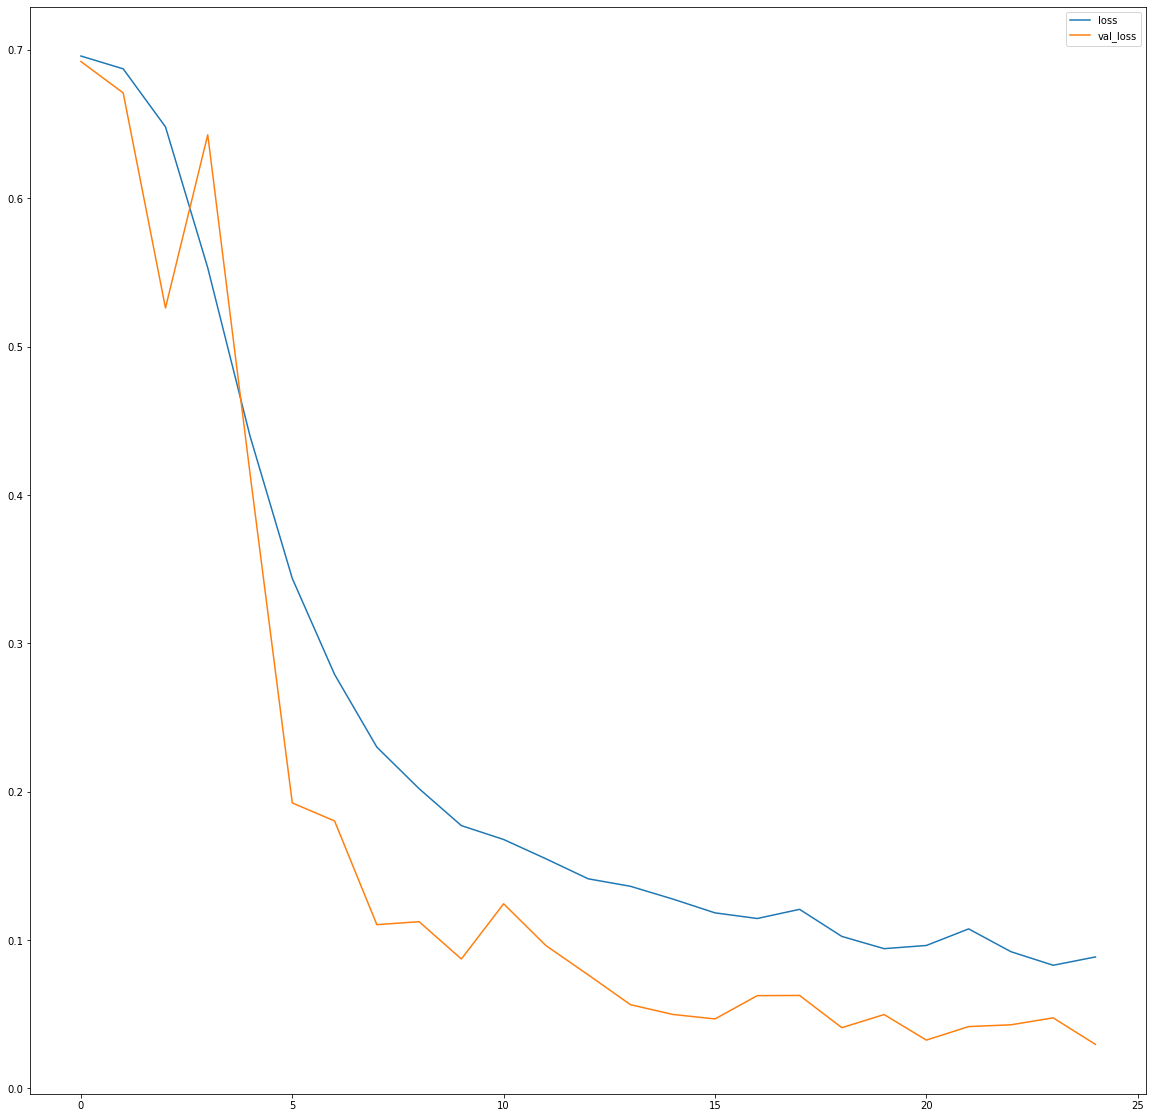

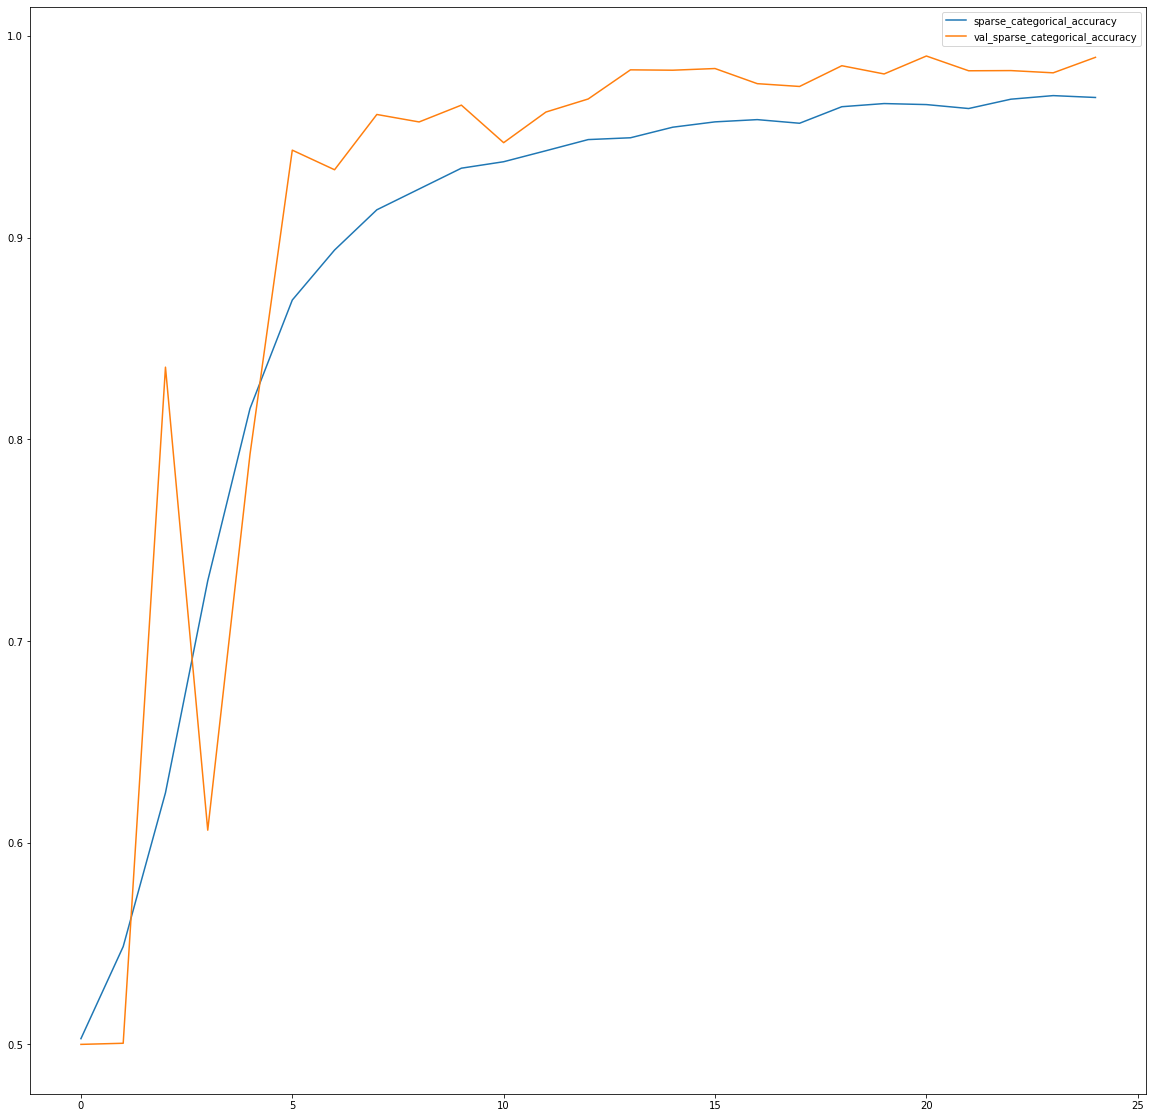

In [13]:
plot_learning_curve(train_history)

Training Results: 
Accuracy:  0.9882539682539683
Precision:  0.9973590600409615
Recall:  0.9791005291005291
F1 Score:  0.9881454584290063
Validation Results: 
Accuracy:  0.9893518518518518
Precision:  0.997927265875259
Recall:  0.9807407407407407
F1 Score:  0.9892593630335295
Combined Results: 
Accuracy:  0.987037037037037
Precision:  0.9969765684051398
Recall:  0.977037037037037
F1 Score:  0.9869060980172091


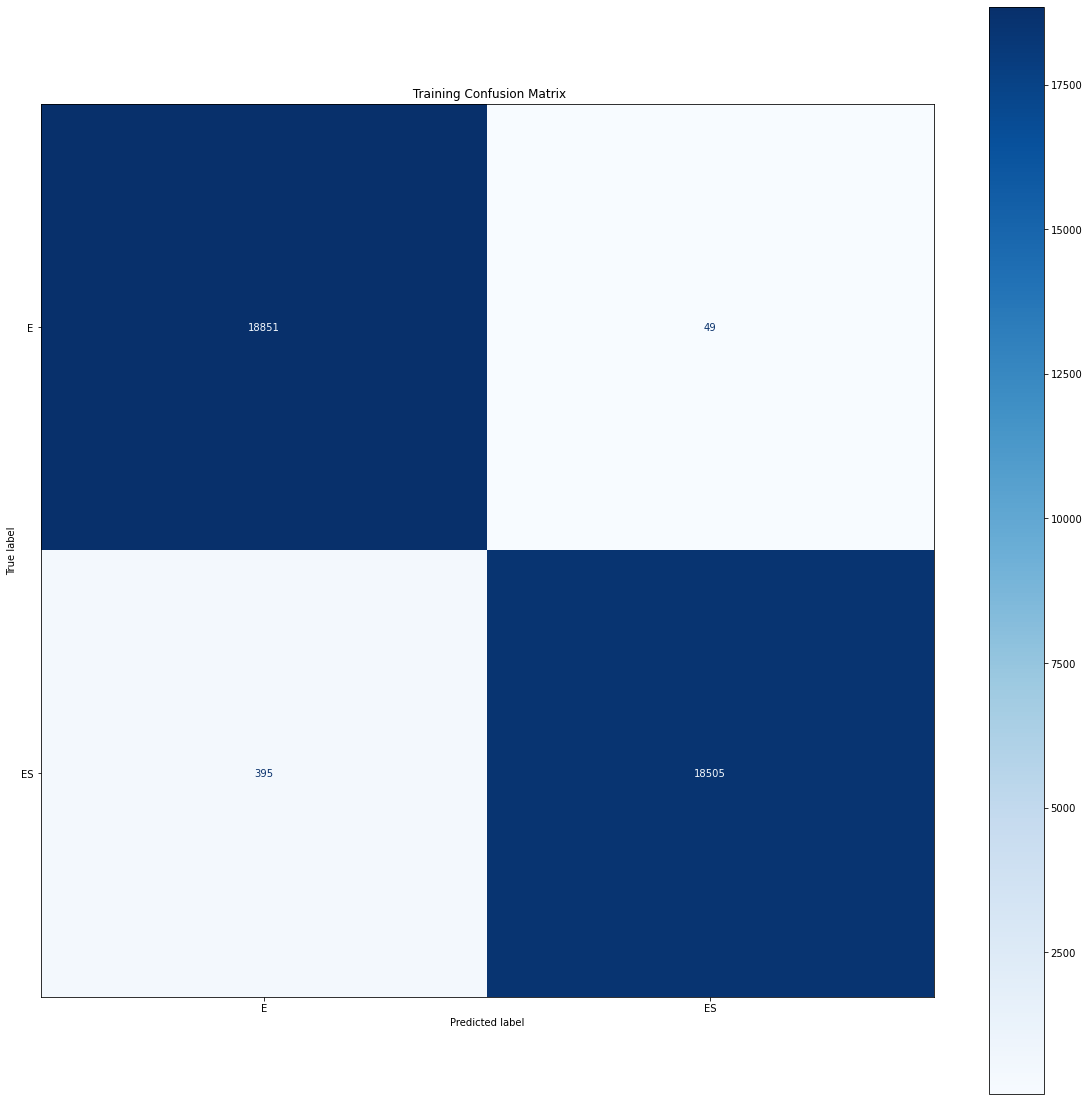

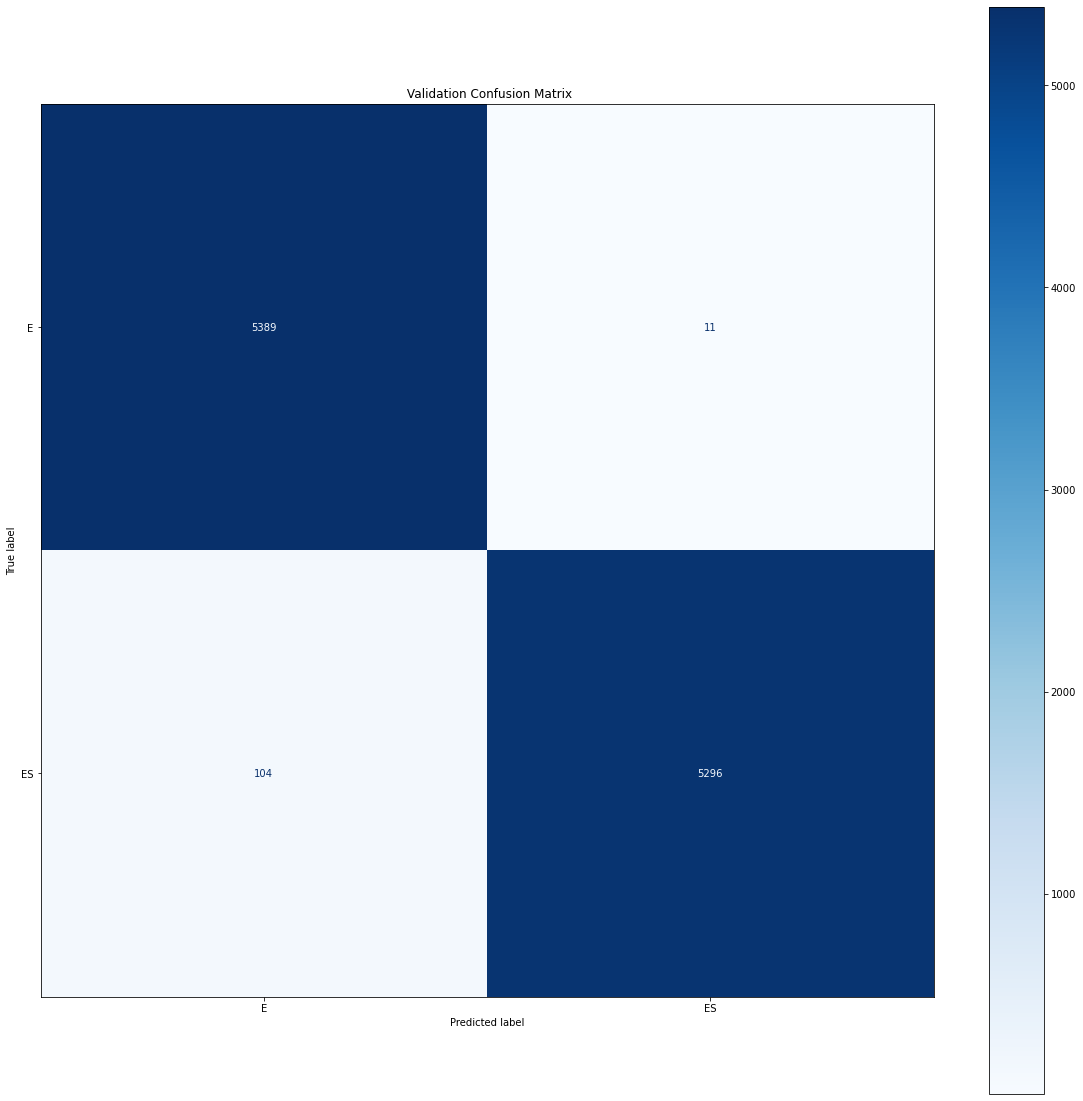

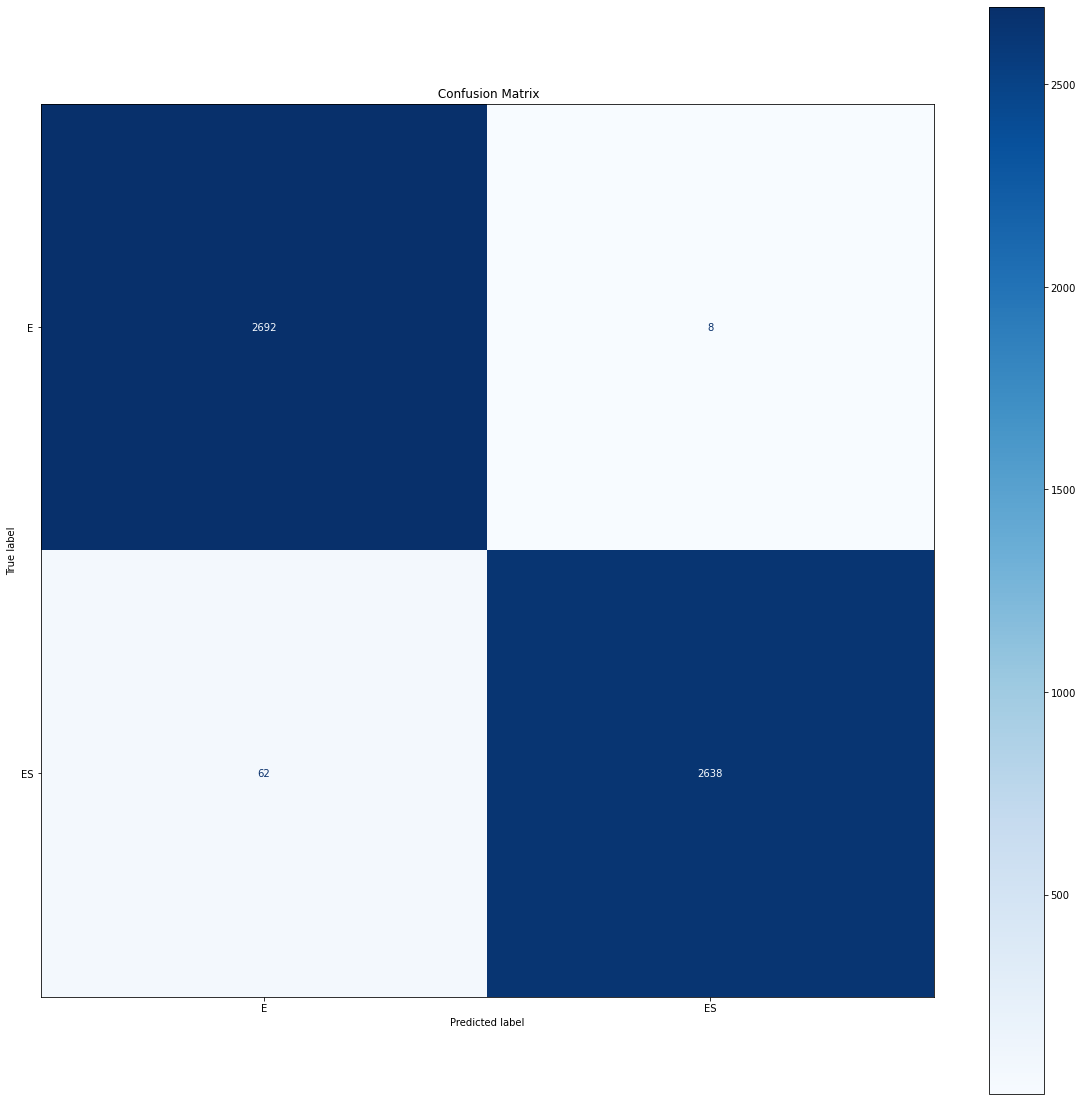

In [14]:
plot_model_results(model, x_train, y_train, x_val, y_val, x_test, y_test)

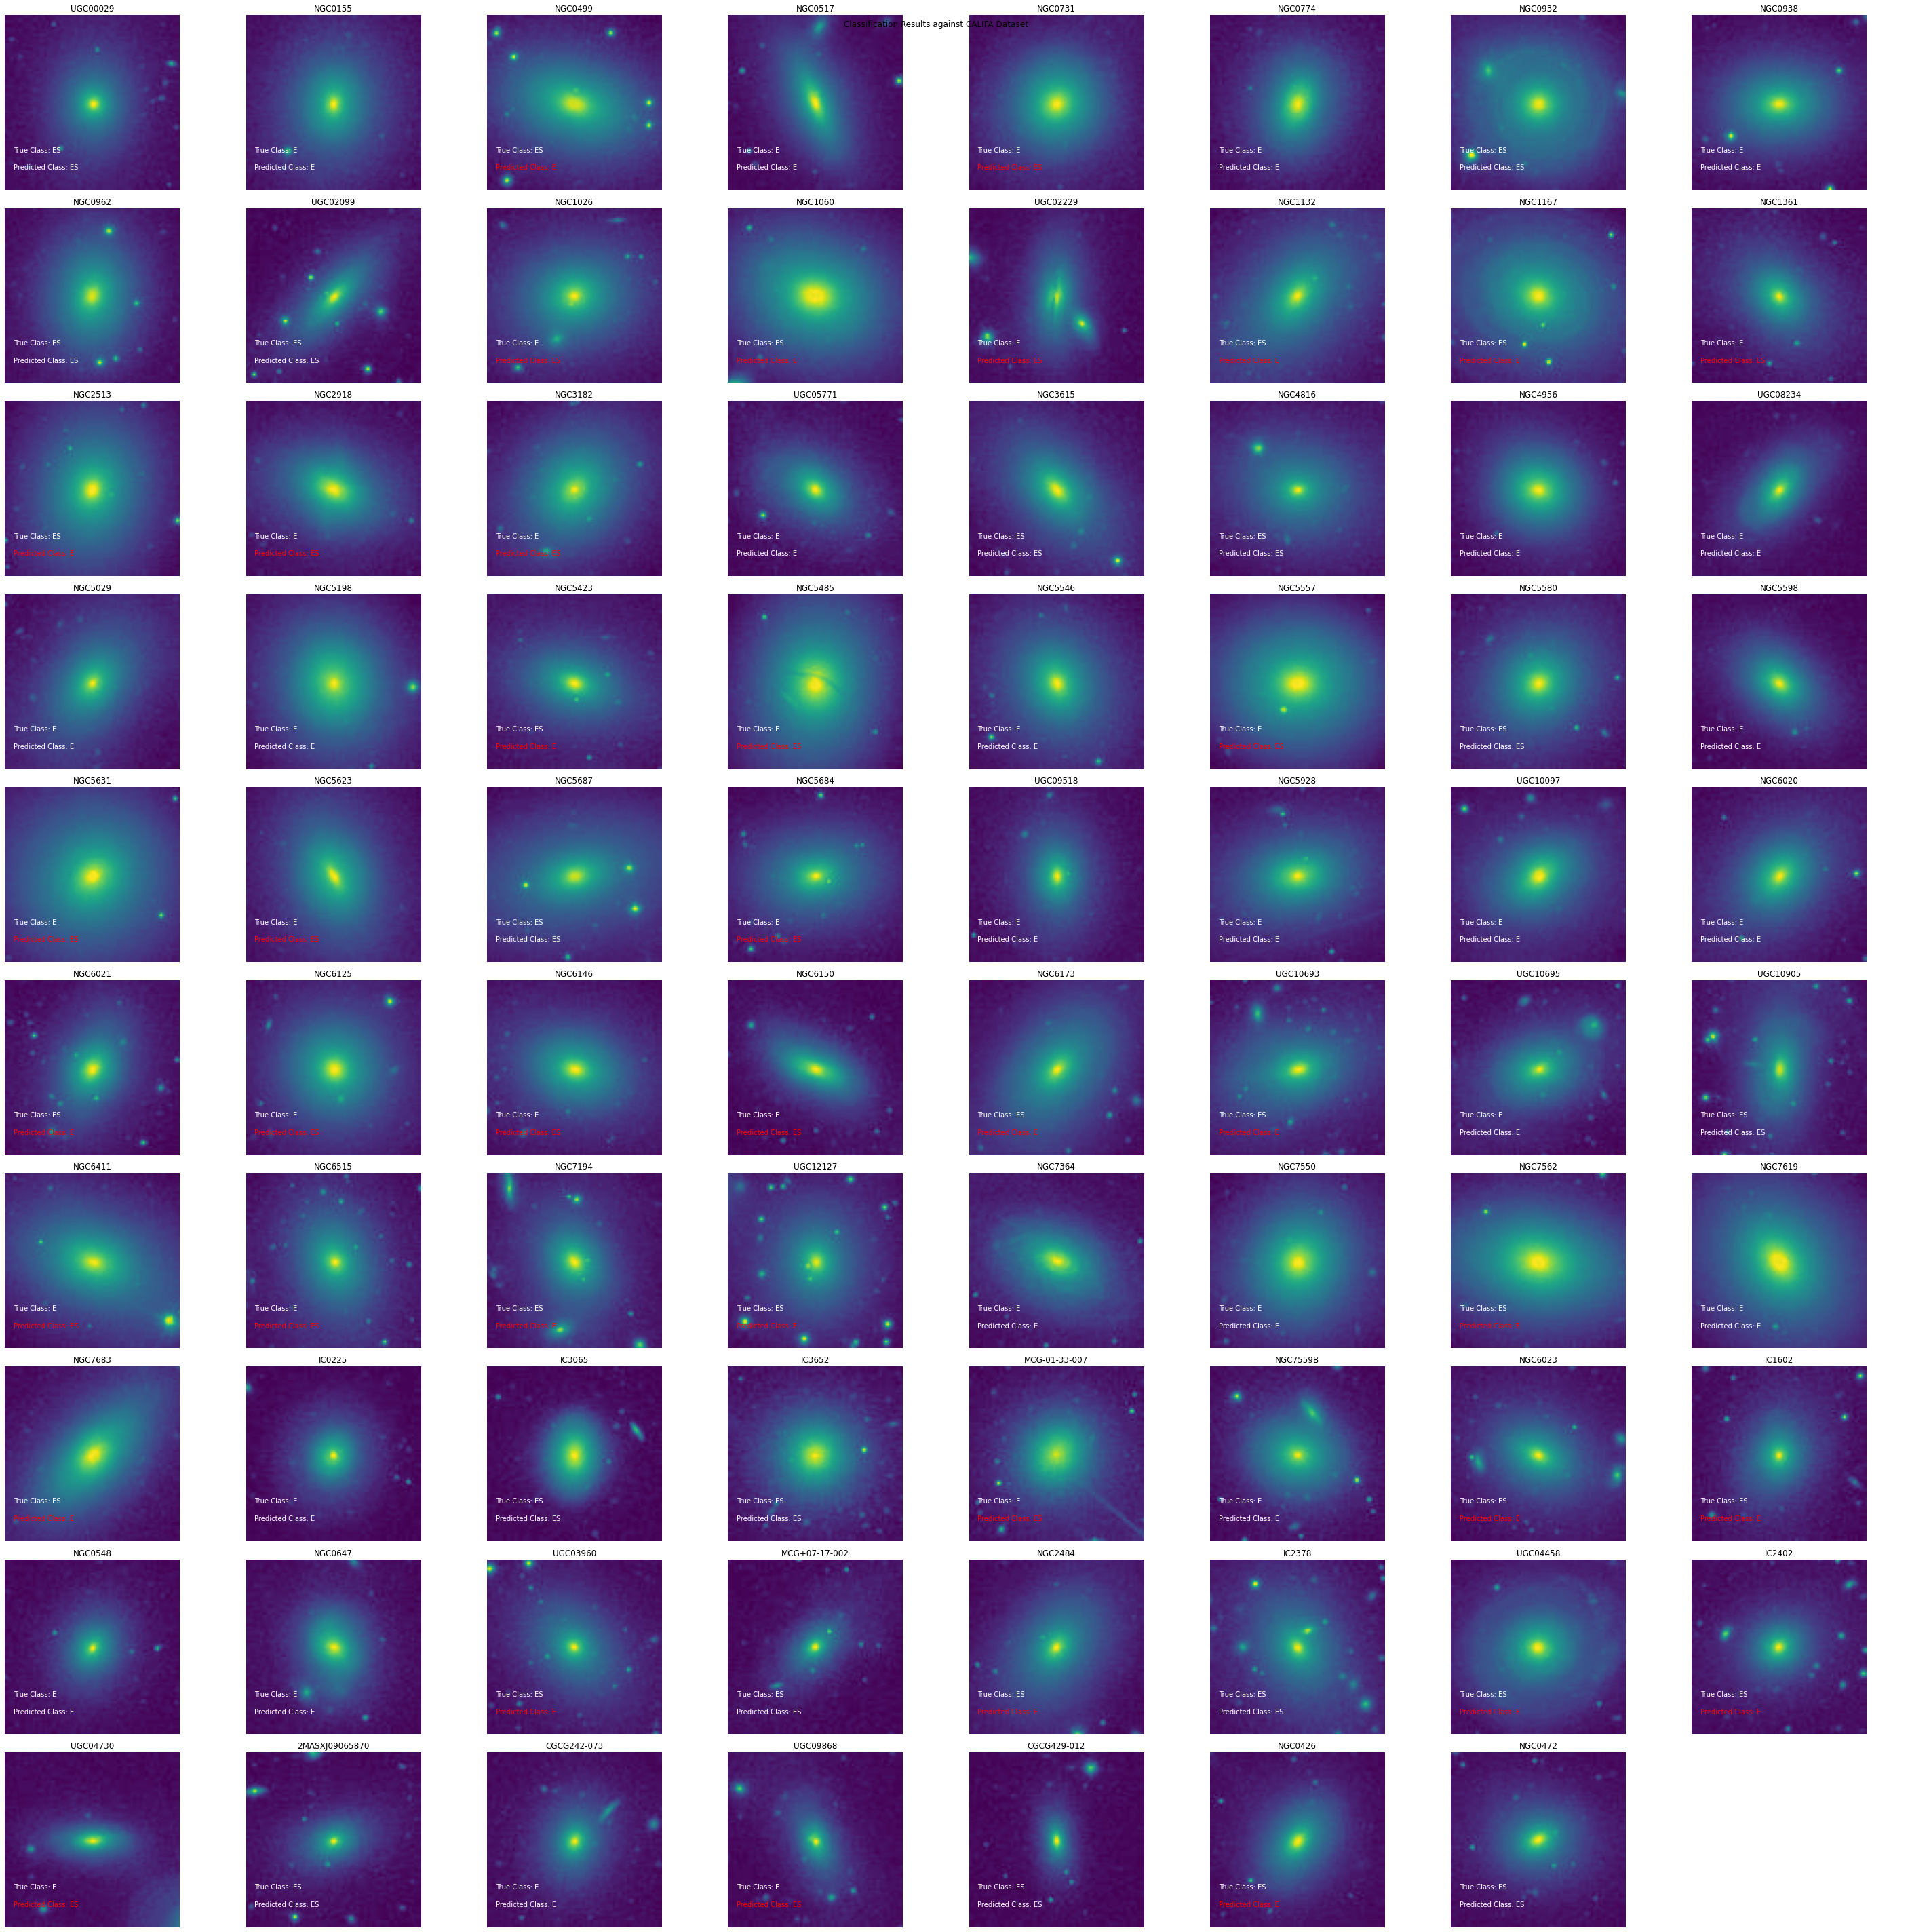

In [15]:
plot_classification_results_new(images=x_cal, metadata=metadata, title="Classification Results against CALIFA Dataset", display_size=(10, 8), random_sample=False, predicted_classes = model.predict(x_test).argmax(axis=1))
# plot_classification_results(images=x_test, display_size=(10, 8), y_preds=model.predict(x_test).argmax(axis=1), y_trues=y_test,
#                             y_labels=("E", "ES"),
#                             galaxy_names=metadata["name"], random_sample=True)

In [16]:
model.save(model_name, overwrite=True)
score = model.evaluate(x_test, y_test, verbose=0)
print(score)
np.savetxt(model_name + "\\loss_" + str(score[0]) + "_accuracy_" + str(score[1]), np.array([]))

INFO:tensorflow:Assets written to: saved_models\result_models\sim_with_gaussian_noise\assets
[0.034849997609853745, 0.9870370626449585]


In [17]:
x_cal.shape

(79, 100, 100, 1)